In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# Verifique se CUDA está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [4]:
# Preprocess MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Example usage

# Parameters
input_dim = 784  # Dimension of input (28x28 pixels images in MNIST)
label_dim = 10  # Dimension of labels (10 classes in MNIST)
hidden_dim = 256  # Hidden dimension of encoder and decoder
latent_dim = 10  # Dimension of latent representation

In [12]:
class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super(CVAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)  # new layer
        self.fc_mean = nn.Linear(hidden_dim//2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim//2, latent_dim)
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim + label_dim, hidden_dim//2)  # new layer
        self.fc4 = nn.Linear(hidden_dim//2, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x, y):
        input = torch.cat((x, y), dim=1)
        hidden = F.relu(self.fc1(input))
        hidden = F.relu(self.fc2(hidden))  # new layer
        mean = self.fc_mean(hidden)
        logvar = self.fc_logvar(hidden)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        return z
    
    def decode(self, z, y):
        input = torch.cat((z, y), dim=1)
        hidden = F.relu(self.fc3(input))  # new layer
        hidden = F.relu(self.fc4(hidden))
        reconstructed = torch.sigmoid(self.fc5(hidden))
        return reconstructed
    
    def forward(self, x, y):
        mean, logvar = self.encode(x, y)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z, y)
        return reconstructed, mean, logvar
        
def loss_function(reconstructed, x, mean, logvar):
    # Reconstruction loss (binary cross-entropy)
    reconstruction_loss = F.binary_cross_entropy(reconstructed, x, reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = reconstruction_loss + kl_loss
    return total_loss

# Create the CVAE model
model = CVAE(input_dim, label_dim, hidden_dim, latent_dim)
model = model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:

# Training
def train(model, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.view(-1, input_dim).to(device)
            labels = F.one_hot(labels, num_classes=10).type(torch.float).to(device)  # One-hot encoding of labels
            optimizer.zero_grad()
            
            reconstructed, mean, logvar = model(data, labels)
            
            loss = loss_function(reconstructed, data, mean, logvar)
            
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            # Print training information
            if batch_idx % 100 == 0:
                print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item()))
        
        print('Epoch [{}/{}], Average Loss: {:.4f}'
              .format(epoch+1, num_epochs, train_loss/len(train_loader)))

# Call the training function
num_epochs = 10
train(model, optimizer, num_epochs)

Epoch [1/10], Batch [1/469], Loss: 69222.4062
Epoch [1/10], Batch [101/469], Loss: -3736838.5000
Epoch [1/10], Batch [201/469], Loss: -3857627.2500
Epoch [1/10], Batch [301/469], Loss: -4111484.2500
Epoch [1/10], Batch [401/469], Loss: -4399958.0000
Epoch [1/10], Average Loss: -3715073.3481
Epoch [2/10], Batch [1/469], Loss: -4503689.0000
Epoch [2/10], Batch [101/469], Loss: -4704314.0000
Epoch [2/10], Batch [201/469], Loss: -4802715.5000
Epoch [2/10], Batch [301/469], Loss: -4852908.5000
Epoch [2/10], Batch [401/469], Loss: -4732815.5000
Epoch [2/10], Average Loss: -4748143.6471
Epoch [3/10], Batch [1/469], Loss: -4734724.5000
Epoch [3/10], Batch [101/469], Loss: -4691335.0000
Epoch [3/10], Batch [201/469], Loss: -4694139.0000
Epoch [3/10], Batch [301/469], Loss: -4676881.0000
Epoch [3/10], Batch [401/469], Loss: -4871535.5000
Epoch [3/10], Average Loss: -4887017.8619
Epoch [4/10], Batch [1/469], Loss: -5243799.0000
Epoch [4/10], Batch [101/469], Loss: -4855163.5000
Epoch [4/10], Batc

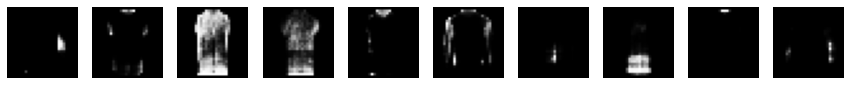

In [20]:
import matplotlib.pyplot as plt

# Generate new samples
def generate_samples(model, num_samples, label):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        y = torch.zeros(num_samples, label_dim).to(device)
        y[:, label] = 1
        generated_samples = model.decode(z, y)
    return generated_samples

num_samples = 10
generated_samples = generate_samples(model, num_samples, 0)  # 0 é o label de camisas

generated_samples = generated_samples.view(-1, 28, 28)
generated_samples = (generated_samples * 0.5) + 0.5  # desfazendo a normalização

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(generated_samples[i].cpu().numpy(), cmap='gray')
    axes[i].axis('off')
plt.show()